# Moment of truth for Flipper

In this notebook we assess the performance of a Binary classifier trained on Dolphin sounds.  

Flipper is a deep learning classifier that we trained to determine whether a sound file contains dolphin clicks. 

##Importing Packages and Libraries

In [ ]:
!pip install ketos

In [2]:
import os

In [3]:
import pandas as pd
import ketos.neural_networks.dev_utils.detection as det
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioFrameLoader
from ketos.neural_networks.resnet import ResNetInterface
from ketos.neural_networks.dev_utils.detection import process, save_detections
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
from google.colab import files
flipper = files.upload()

In [6]:
#importing the model
model, audio_repr = ResNetInterface.load_model_file(model_file='/content/Flipper_06_13epochs.kt', new_model_folder='./flip_tmp_folder', load_audio_repr=True)

In [7]:
#inspecting spectrogram parameters
spec_config = audio_repr[0]['spectrogram']
spec_config

{'duration': 3.0,
 'freq_max': 100000,
 'freq_min': 0,
 'step': 0.035,
 'type': 'MagSpectrogram',
 'window': 0.085,
 'window_func': 'hamming'}

Uploading a .wav file of 2 min that contains background noise and clicks <br>
Basically it is 1 min noise and then 1 min noise+clicks.

In [9]:
#Loading data frame by frame
audio_loader = AudioFrameLoader(path='/content/', step=1.5, repres=spec_config)

Loading 30 seconds frames from the audio file

In [10]:
first_spec = next(audio_loader) #load the first 3.0-s frame
second_spec = next(audio_loader) #load the second 3.0-s frame
third_spec = next(audio_loader) #load the second 3.0-s frame
# etc

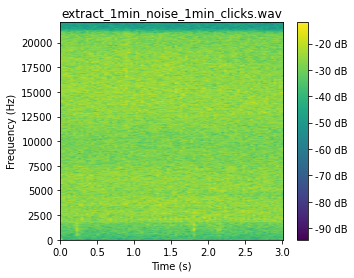

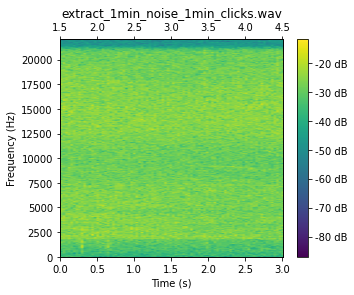

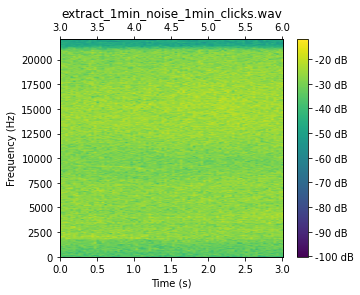

In [11]:
first_spec.plot()
second_spec.plot()
third_spec.plot()
plt.show()

In [12]:
print(audio_loader.num()) #how many frames are there?

7


In [13]:
#resets the audio loader to the 1st frame
audio_loader.reset()

## Feeding the frames to the classifier

In [14]:
#Feeding the frames to the classifier
spec = next(audio_loader) #load a spectrogram
data = spec.get_data()    #extract the pixel values as a 2d array
output = model.run_on_instance(data) #pass the pixel values to the classifier
print(output) #print the classifier's output

(array([1]), array([0.6736255], dtype=float32))


In [15]:
label = output[0][0]
score = output[1][0]
print(f'label: {label}')
print(f'score: {score}')

label: 1
score: 0.6736255288124084


##The Process method:

We can tweak some parameters to have optimum detection:

* **Tresholding:** this is a treshold above which a signal is considered positive. If the treshold is too low there might be false positives, and if it is too high we might miss clicks and have false negatives.

* **Grouping:** This metric was engineered for the detection of whale upcalls. The whales' upcalls tend to cluster together (see our [notebook](https://github.com/DSTI-ClickLearn/ClickLearn_DSTI_Project/blob/main/Models/Testing_Mobydick's_performance.ipynb) on the whale sound detection). Therefore we have to group the positive signals that are close to gether in order not to have false positives. In the case of whales, setting the `group` argument to `True` groups adjacent detections into a single detection with the combined duration. <br>
Dolphins make trains of clicks and not individual calls therefore this argument is not relevant to our case.   

In [16]:
audio_loader.reset() #reset the audio loader before processing
detections = process(audio_loader, model=model, batch_size=64, progress_bar=True)

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


In [17]:
for d in detections[:6]:
    print(d)

('extract_1min_noise_1min_clicks.wav', 0.0, 3.0109750566893427, 0.6736255)
('extract_1min_noise_1min_clicks.wav', 1.5, 3.0109750566893427, 0.6827318)
('extract_1min_noise_1min_clicks.wav', 3.0, 3.0109750566893427, 0.6669529)
('extract_1min_noise_1min_clicks.wav', 4.5, 3.0109750566893427, 0.67672795)
('extract_1min_noise_1min_clicks.wav', 6.0, 3.0109750566893427, 0.6824643)
('extract_1min_noise_1min_clicks.wav', 7.5, 3.0109750566893427, 0.68894917)


In [18]:
#tresholding at 0.7
detections_t07 = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=False, threshold=0.7)

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


In [20]:
save_detections(detections=detections, save_to='detections.csv')

In [21]:
save_detections(detections=detections_t07, save_to='detectionsTres.csv')

## No treasholding

In [26]:
df = pd.read_csv('/content/detections.csv')
print (df)

    start     score
0     0.0  0.673625
1     1.5  0.682732
2     3.0  0.666953
3     4.5  0.676728
4     6.0  0.682464
..    ...       ...
75  111.0  0.930780
76  112.5  0.907593
77  114.0  0.902423
78  115.5  0.940092
79  117.0       NaN

[80 rows x 2 columns]


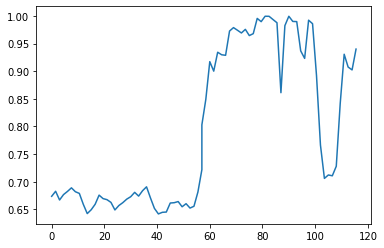

In [31]:
plt.plot(df['start'],df['score'])
plt.xlabel=('time (sec)')
plt.ylabel=('score')
plt.show()

The score coresponds to the score given by the model to a specific spectrogram. We know for a fact that in this audio recording there are no dolphin sounds in the first 60 secods. Still the model gives a score of >60% of it containing dolphin sounds. 

## With Tresholding 
We can set a tresholding of 0.7 to eliminate the false positives. 

In [32]:
df2 = pd.read_csv('/content/detectionsTres.csv')
print (df2)

    start     score
0     0.0  0.000000
1     1.5  0.000000
2     3.0  0.000000
3     4.5  0.000000
4     6.0  0.000000
..    ...       ...
75  111.0  0.841757
76  112.5  0.930780
77  114.0  0.907593
78  115.5  0.902423
79  117.0  0.940092

[80 rows x 2 columns]


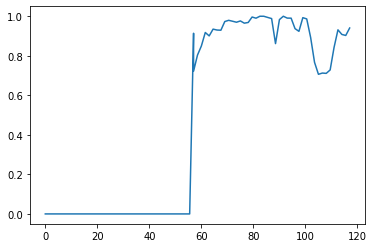

In [33]:
plt.plot(df2['start'],df2['score'])
plt.xlabel=('time (sec)')
plt.ylabel=('score')
plt.show()